In [1]:
# Required modules
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import trange, tqdm
import ot

# Required dependencies
import sketch as sketch
import utils as utils
import cuda as cuda
import plot as plot

In [2]:
cuda.check_for_CUDA()

Is CUDA supported by this system? False


We set basic parameters to solve the Quadratic Entropy Regularization.

In [6]:
# parameters
n = 300 # probability vectors in \R^n
epsilon = 1 # regularization parameter
max_iter = 5000

We initialize two marginal probability vectors $\mu_1 \in \mathbb{R}^n$ and $\mu_2 \in \mathbb{R}^n$.

In [9]:
mu_1 = sketch.compute_marginals(-5, 5, n, [0, 2], [0.4, 0.6])
mu_2 = sketch.compute_marginals(-5, 5, n, [-2, 0.2], [1, 0.5])

Let us visualize and save $\mu_1 \in \mathbb{R}^n$ and $\mu_2 \in \mathbb{R}^n$.

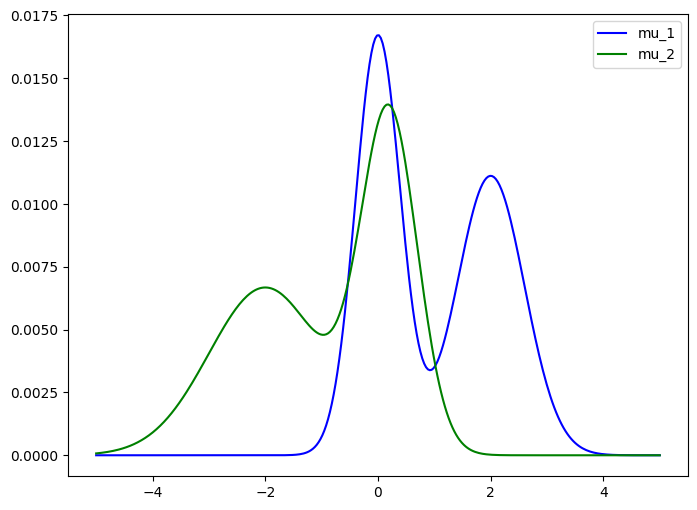

In [12]:
plot.plot_vectors(-5,5,n,[mu_1,mu_2],["mu_1","mu_2"])
utils.save_tensors([mu_1,mu_2],["mu_1","mu_2"])

We initialize cost matrix $C \in \mathbb{R}_{+}^{n\times n}$ with respect to Euclidean and Coulomb cost functions. There are two types of Coulomb cost functions. The strong coulomb cost is the original definition of coulomb cost, i.e. $\forall i,j \in [n]$ we have
$$
C_{str}(i,j) = \begin{cases}
    \frac{1}{\lvert i-j \rvert} & i \neq j \\
    +\infty & i = j \\
    \end{cases}
$$
The weak coulomb cost is the modified version of strong coulomb cost to avoid the blow up behavior of the Sinkhorn algorithm. $\forall i, j \in [n]$, we have
$$
C_{weak}(i,j) = \begin{cases}
        \frac{1}{n\lvert i - j \rvert} & i \neq j \\
        1 & i = j \\
    \end{cases}
$$

In [15]:
# Generate cost matrices
C_euc = sketch.compute_euclidean_cost(n)
C_scou = sketch.compute_strong_coulomb_cost(n)
C_wcou = sketch.compute_weak_coulomb_cost(n)

Compute Euclidean Cost...
Computing Strong Coulomb Cost...
Computing Weak Coulomb Cost...


Let us plot each cost matrix with respect to different governing principles.

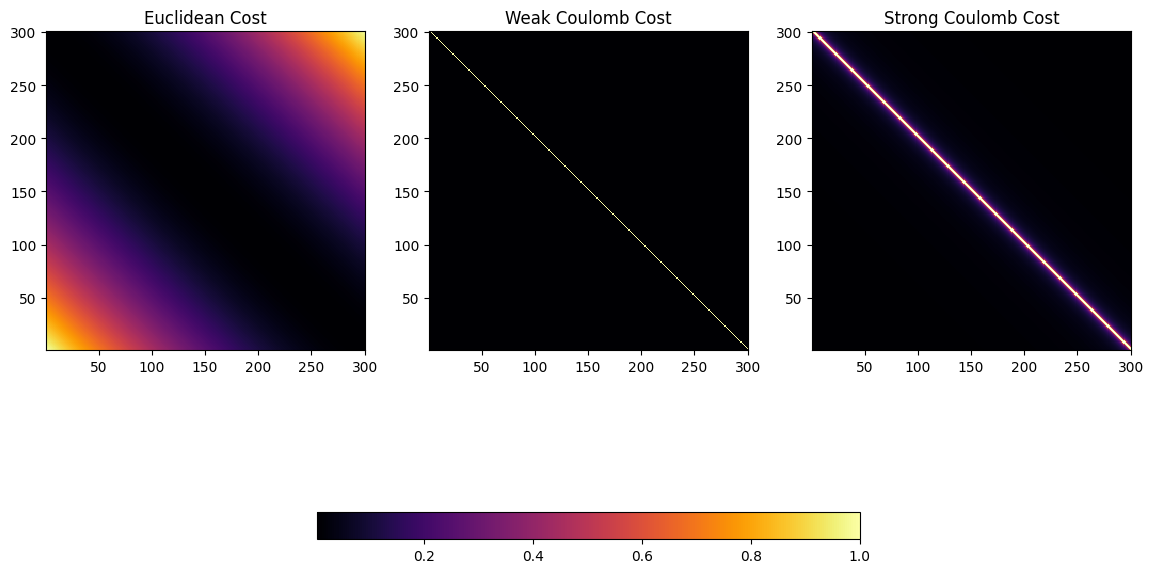

In [18]:
plot.plot_matrices([C_euc, C_wcou, C_scou], ["Euclidean Cost", "Weak Coulomb Cost", "Strong Coulomb Cost"],save=True,filename="cost_plot")
utils.save_tensors([C_euc, C_wcou, C_scou], ["Euclidean Cost", "Weak Coulomb Cost", "Strong Coulomb Cost"])

In [13]:
# Run Cyclic Projection algorithm with cost tensor C and 2 marginal vectors (a,b) on cuda:gpu_device_num
def sinkhorn_quadratic_cyclic_projection(C: torch.Tensor, a: torch.Tensor, b: torch.Tensor,
                                         epsilon: torch.float64, gpu_device_num: int = 0, num_iter: int = max_iter,
                                         convergence_error: float = 1e-8, log=False) -> torch.Tensor:

    print("Running Cyclic Projection...")
    
    n = a.size()[0]
    m = b.size()[0]
    f = torch.zeros_like(a)
    g = torch.zeros_like(b)

    # Use CUDA if possible
    cuda.transfer_to_GPU([f,g], gpu_device_num)
    
    for it in trange(num_iter):
        f_prev = f
        g_prev = g
        rho = -(f.expand_as(C.T).T + g.expand_as(C) - C).clamp(max=0)
        f = (epsilon * a - (rho + g.expand_as(C) - C).sum(1)) / m
        g = (epsilon * b - (rho + f.expand_as(C.T).T - C).sum(0)) / n
        f_diff = (f_prev - f).abs().sum()
        g_diff = (g_prev - g).abs().sum()
        if log:
            print(f"Iteration {it}")
            print(f"f_diff {f_diff}")
            print(f"g_diff {g_diff}")
        if f_diff < convergence_error and g_diff < convergence_error:
            break

    cyclic_projection = ((f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon).cpu() # Retrieve result to CPU

    torch.cuda.empty_cache()
    
    return cyclic_projection

In [14]:
def sinkhorn_quadratic_gradient_descent(C: torch.Tensor, a: torch.Tensor, b: torch.Tensor, epsilon: torch.float64,
                                        gpu_device_num: int = 0, num_iter: int = max_iter,
                                        convergence_error: float = 1e-8, log=False) -> torch.Tensor:

    print("Gradient Descent")
    
    n = a.size()[0]
    m = b.size()[0]
    f = torch.zeros_like(a)
    g = torch.zeros_like(b)
    step = 1.0 / (m + n)

    # Use CUDA if possible
    cuda.transfer_to_GPU([f,g], gpu_device_num)

    for it in trange(num_iter):
        f_prev = f.clone()
        g_prev = g.clone()

        P = (f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon

        f -= step * epsilon * (P.sum(1) - a)
        g -= step * epsilon * (P.sum(0) - b)

        f_diff = (f_prev - f).abs().sum()
        g_diff = (g_prev - g).abs().sum()

        if log:
            print(f"Iteration {it}")
            print(f"f_diff {f_diff}")
            print(f"g_diff {g_diff}")

        if f_diff < convergence_error and g_diff < convergence_error:
            break

    gradient_descent = ((f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon).cpu() # Retrieve result to CPU

    torch.cuda.empty_cache()
    
    return gradient_descent

In [15]:
def sinkhorn_quadratic_fixed_point_iteration(C: torch.Tensor, a: torch.Tensor, b: torch.Tensor, epsilon: torch.float64,
                                             gpu_device_num: int = 0, num_iter: int = max_iter,
                                             convergence_error: float = 1e-8, log=False) -> torch.Tensor:

    print("Fixed Point Iteration")
    
    n = a.size()[0]
    m = b.size()[0]
    f = torch.zeros_like(a)
    g = torch.zeros_like(b)

    # Use CUDA if possible
    cuda.transfer_to_GPU([f,g], gpu_device_num)

    for it in trange(num_iter):
        f_prev = f.clone()
        g_prev = g.clone()

        P = (f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon
        v = - epsilon * (P.sum(1) - a)
        f += (v - v.sum() / (2 * n)) / m
        u = - epsilon * (P.sum(0) - b)
        g += (u - u.sum() / (2 * m)) / n

        f_diff = (f_prev - f).abs().sum()
        g_diff = (g_prev - g).abs().sum()

        if log:
            print(f"Iteration {it}")
            print(f"f_diff {f_diff}")
            print(f"g_diff {g_diff}")

        if f_diff < convergence_error and g_diff < convergence_error:
            break

    fixed_point_iteration = ((f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon).cpu()

    torch.cuda.empty_cache()
    
    return fixed_point_iteration

In [16]:
def sinkhorn_quadratic_nesterov_gradient_descent(C: torch.Tensor, a: torch.Tensor, b: torch.Tensor, epsilon: torch.float64, 
                                                 gpu_device_num: int = 0, num_iter: int = max_iter,
                                                 convergence_error: float = 1e-8, log=False) -> torch.Tensor:

    print("Nesterov Gradient Descent")
    
    n = a.size()[0]
    m = b.size()[0]
    f = torch.zeros_like(a)
    g = torch.zeros_like(b)
    step = 1.0 / (m + n)

    # Use CUDA if possible
    cuda.transfer_to_GPU([f,g],gpu_device_num)

    f_previous = f
    g_previous = g

    for it in trange(num_iter):
        f_p = f + n * (f - f_previous) / (n + 3)
        g_p = g + n * (g - g_previous) / (n + 3)

        P = (f_p.expand_as(C.T).T
             + g_p.expand_as(C) - C).clamp(min=0) / epsilon

        f_new = f_p - step * epsilon * (P.sum(1) - a)
        g_new = g_p - step * epsilon * (P.sum(0) - b)

        f_diff = (f_previous - f_new).abs().sum()
        g_diff = (g_previous - g_new).abs().sum()

        f_previous = f
        g_previous = g

        f = f_new
        g = g_new

        if log:
            print(f"Iteration {it}")
            print(f"f_diff {f_diff}")
            print(f"g_diff {g_diff}")

        if f_diff < convergence_error and g_diff < convergence_error:
            break

    nesterov_gradient_descent = ((f.expand_as(C.T).T + g.expand_as(C) - C).clamp(min=0) / epsilon).cpu()

    torch.cuda.empty_cache()
    
    return nesterov_gradient_descent

In [17]:
def sinkhorn_quadratic_nesterov_gradient_descent3(cost: torch.Tensor, marg1: torch.Tensor, marg2: torch.Tensor, marg3: torch.Tensor,
                                                  epsilon: torch.float64, gpu_device_num: int = 0,
                                                  num_iter: int = 50000, convergence_error: float = 1e-8, log=False) -> torch.Tensor:
    
    print("Nesterov Gradient Descent 3 marginals")
    
    n1 = marg1.size()[0]
    n2 = marg2.size()[0]
    n3 = marg3.size()[0]
    p1 = torch.zeros_like(marg1)
    p2 = torch.zeros_like(marg2)
    p3 = torch.zeros_like(marg3)
    step = 1.0 / (n1 + n2 + n3)
    p1_prev = p1
    p2_prev = p2
    p3_prev = p3

    # Use CUDA if possible
    transfer_to_GPU([p1,p2,p3,p1_prev,p2_prev,p3_prev], gpu_device_num)

    for it in trange(num_iter):
        p1_p = p1 + n1 * (p1 - p1_prev) / (n1 + 3)
        p2_p = p2 + n2 * (p2 - p2_prev) / (n2 + 3)
        p3_p = p3 + n3 * (p3 - p3_prev) / (n3 + 3)

        P = (p1.expand_as(cost.T).T
             + p2.expand_as(cost.permute(0, 2, 1)).permute(0, 2, 1)
             + p3.expand_as(cost) - cost).clamp(min=0) / epsilon

        p1_new = p1_p - step * epsilon * (P.sum((1, 2)) - marg1)
        p2_new = p2_p - step * epsilon * (P.sum((0, 2)) - marg2)
        p3_new = p3_p - step * epsilon * (P.sum((0, 1)) - marg3)

        p1_diff = (p1_prev - p1_new).abs().sum()
        p2_diff = (p2_prev - p2_new).abs().sum()
        p3_diff = (p3_prev - p3_new).abs().sum()

        p1_prev = p1
        p2_prev = p2
        p3_prev = p3

        p1 = p1_new
        p2 = p2_new
        p3 = p3_new

        if log:
            print(f"Iteration {it}")
            print(f"p1_diff {p1_diff}")
            print(f"p2_diff {p2_diff}")
            print(f"p3_diff {p3_diff}")

        if p1_diff < convergence_error and p2_diff < convergence_error and p2_diff < convergence_error:
            break

    nesterov_gradient_descent3 = ((p1.expand_as(cost.T).T + p2.expand_as(cost.permute(0, 2, 1)).permute(0, 2, 1) + p3.expand_as(cost) - cost).clamp(min=0) / epsilon).cpu()

    torch.cuda.empty_cache()
    
    return nesterov_gradient_descent3

In [51]:
def test_euc(gpu_device_num):
    cuda.transfer_to_GPU([C_scou,mu_1,mu_2],gpu_device_num) # send common resource to GPU
    P_cyclic_euc = sinkhorn_quadratic_cyclic_projection(C_euc, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num)
    P_grad_euc = sinkhorn_quadratic_gradient_descent(C_euc, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) 
    P_fpi_euc = sinkhorn_quadratic_fixed_point_iteration(C_euc, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) 
    P_nesterov_euc = sinkhorn_quadratic_nesterov_gradient_descent(C_euc, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num)
    print(list(map(torch.sum,[P_cyclic_euc,P_grad_euc,P_fpi_euc,P_nesterov_euc])))
    plot.plot_matrices([P_cyclic_euc, P_grad_euc, P_fpi_euc, P_nesterov_euc],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
    utils.save_tensors([P_cyclic_euc, P_grad_euc, P_fpi_euc, P_nesterov_euc],
                       ["P_cyclic_euc", "P_grad_euc", "P_fpi_euc", "P_nesterov_euc"])

Running Cyclic Projection...


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1449.40it/s]


Gradient Descent


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1813.40it/s]


Fixed Point Iteration


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1692.90it/s]


Nesterov Gradient Descent


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1677.76it/s]


In [19]:
# Check whether the resulting matrices are doubly stochastic
list(map(torch.sum,[P_cyclic_euc,P_grad_euc,P_fpi_euc,P_nesterov_euc]))

[tensor(1.1262, dtype=torch.float64),
 tensor(1.0739, dtype=torch.float64),
 tensor(1.1262, dtype=torch.float64),
 tensor(1.0006, dtype=torch.float64)]

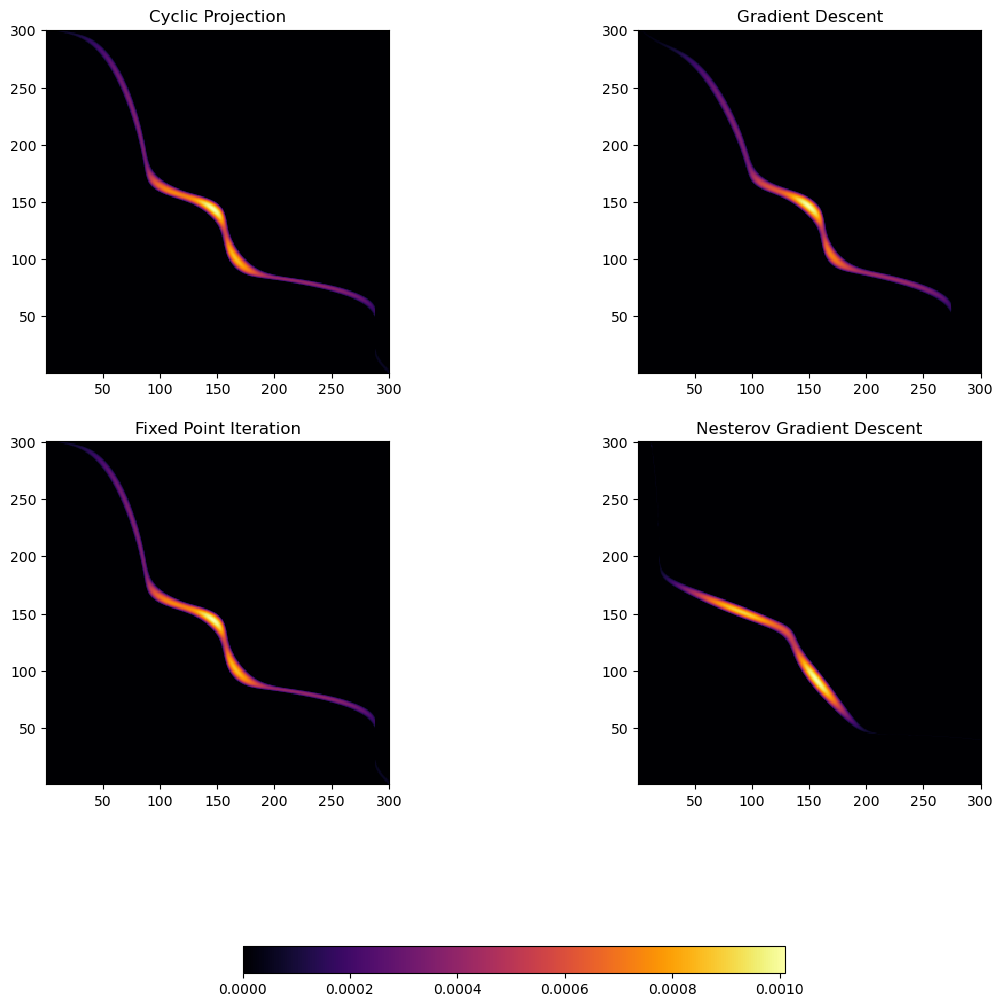

In [20]:
plot.plot_matrices([P_cyclic_euc, P_grad_euc, P_fpi_euc, P_nesterov_euc],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
utils.save_tensors([P_cyclic_euc, P_grad_euc, P_fpi_euc, P_nesterov_euc],
                       ["P_cyclic_euc", "P_grad_euc", "P_fpi_euc", "P_nesterov_euc"])

Let us test these algorithms for Weak Coulomb Cost Matrix

In [22]:
def test_wcou(gpu_device_num):
    cuda.transfer_to_GPU([C_scou,mu_1,mu_2],gpu_device_num) # send common resource to GPU
    P_cyclic_wcou = sinkhorn_quadratic_cyclic_projection(C_wcou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_grad_wcou = sinkhorn_quadratic_gradient_descent(C_wcou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_fpi_wcou = sinkhorn_quadratic_fixed_point_iteration(C_wcou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_nesterov_wcou = sinkhorn_quadratic_nesterov_gradient_descent(C_wcou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    # print the result
    print(list(map(torch.sum,[P_cyclic_wcou,P_grad_wcou,P_fpi_wcou,P_nesterov_wcou])))
    plot.plot_matrices([P_cyclic_wcou, P_grad_wcou, P_fpi_wcou, P_nesterov_wcou],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
    utils.save_tensors([P_cyclic_wcou, P_grad_wcou, P_fpi_wcou, P_nesterov_wcou],
                       ["P_cyclic_scou", "P_grad_scou", "P_fpi_scou", "P_nesterov_scou"])

Running Cyclic Projection...


 42%|███████████████████████████████████▎                                                | 2100/5000 [00:01<00:01, 1522.66it/s]


Gradient Descent


 47%|███████████████████████████████████████▏                                            | 2329/5000 [00:01<00:01, 2012.77it/s]


Fixed Point Iteration


 37%|██████████████████████████████▋                                                     | 1829/5000 [00:01<00:01, 1784.34it/s]


Nesterov Gradient Descent


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1861.48it/s]


In [23]:
# Check whether the resulting matrices are doubly stochastic
list(map(torch.sum,[P_cyclic_wcou, P_grad_wcou, P_fpi_wcou, P_nesterov_wcou]))

[tensor(1.0000, dtype=torch.float64),
 tensor(1.0000, dtype=torch.float64),
 tensor(1.0000, dtype=torch.float64),
 tensor(1.0000, dtype=torch.float64)]

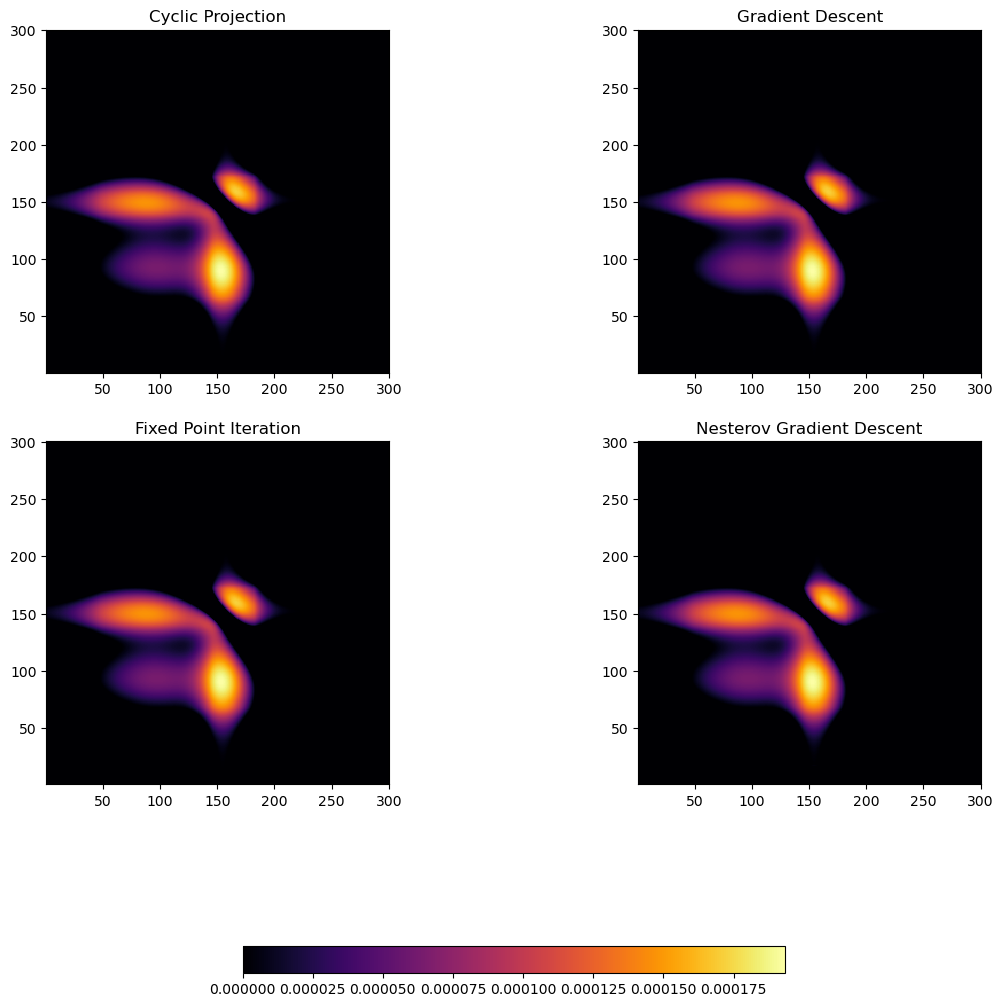

In [24]:
plot.plot_matrices([P_cyclic_wcou, P_grad_wcou, P_fpi_wcou, P_nesterov_wcou],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
utils.save_tensors([P_cyclic_wcou, P_grad_wcou, P_fpi_wcou, P_nesterov_wcou],
                       ["P_cyclic_wcou", "P_grad_wcou", "P_fpi_wcou", "P_nesterov_wcou"])

Let us test these algorithms for Strong Coulomb Cost Matrix

In [26]:
def test_scou(gpu_device_num):
    cuda.transfer_to_GPU([C_scou,mu_1,mu_2],gpu_device_num) # send common resource to GPU
    P_cyclic_scou = sinkhorn_quadratic_cyclic_projection(C_scou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_grad_scou = sinkhorn_quadratic_gradient_descent(C_scou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_fpi_scou = sinkhorn_quadratic_fixed_point_iteration(C_scou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    P_nesterov_scou = sinkhorn_quadratic_nesterov_gradient_descent(C_scou, mu_1, mu_2, epsilon, gpu_device_num=gpu_device_num) # max iteration = 50000, convergence error 1e-8
    # print the result
    print(list(map(torch.sum,[P_cyclic_scou,P_grad_scou,P_fpi_scou,P_nesterov_scou])))
    plot.plot_matrices([P_cyclic_scou, P_grad_scou, P_fpi_scou, P_nesterov_scou],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
    utils.save_tensors([P_cyclic_scou, P_grad_scou, P_fpi_scou, P_nesterov_scou],
                       ["P_cyclic_scou", "P_grad_scou", "P_fpi_scou", "P_nesterov_scou"])

Running Cyclic Projection...


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1512.50it/s]


Gradient Descent


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2051.08it/s]


Fixed Point Iteration


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1790.02it/s]


Nesterov Gradient Descent


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1871.83it/s]


In [27]:
# Check whether the resulting matrices are doubly stochastic
list(map(torch.sum,[P_cyclic_scou,P_grad_scou,P_fpi_scou,P_nesterov_scou]))

[tensor(nan, dtype=torch.float64),
 tensor(1.0530, dtype=torch.float64),
 tensor(1.0339, dtype=torch.float64),
 tensor(0.9999, dtype=torch.float64)]

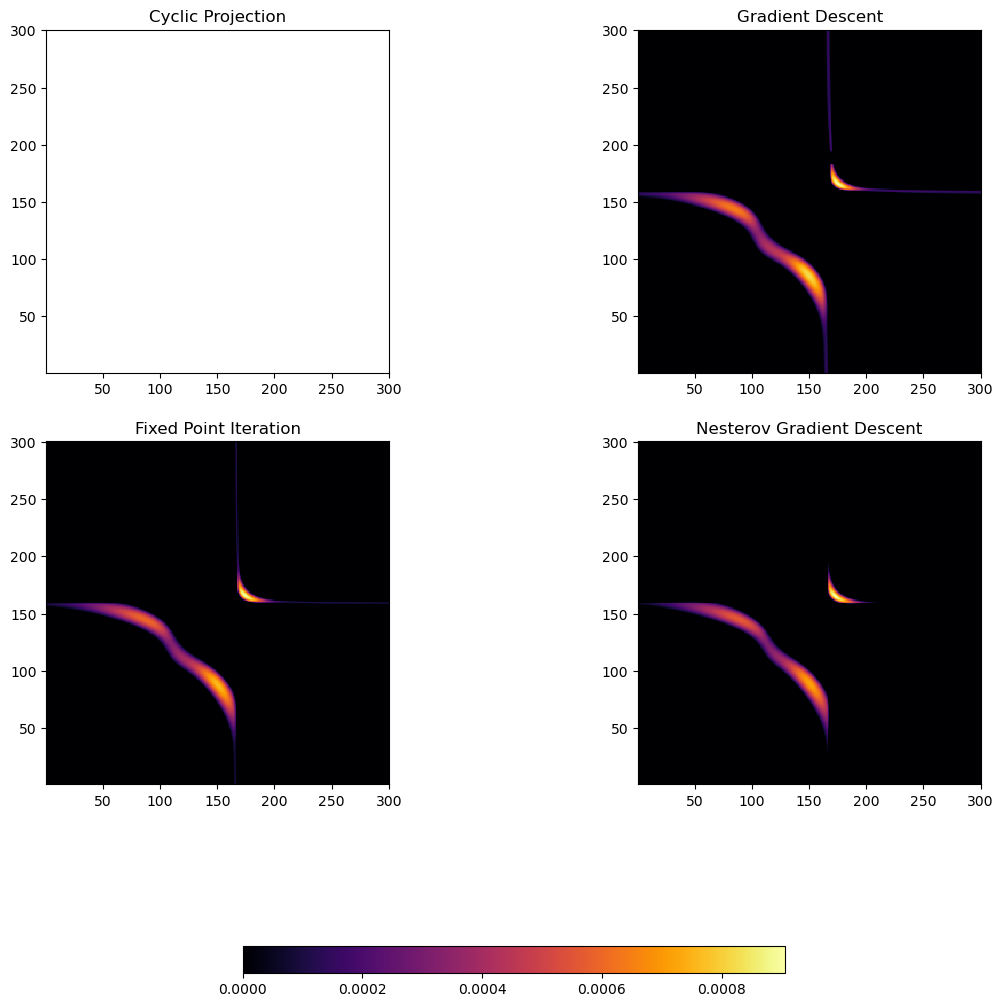

In [28]:
plot.plot_matrices([P_cyclic_scou, P_grad_scou, P_fpi_scou, P_nesterov_scou],
                       ["Cyclic Projection", "Gradient Descent", "Fixed Point Iteration", "Nesterov Gradient Descent"])
utils.save_tensors([P_cyclic_scou, P_grad_scou, P_fpi_scou, P_nesterov_scou],
                       ["P_cyclic_scou", "P_grad_scou", "P_fpi_scou", "P_nesterov_scou"])